# Modeling (Linear Regression)

In [39]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib

from src.config import (
    MASTER_DF_FILE,
    RANDOM_SEED,
    MODELS_DIR,
    MUNICIPALITY_COLUMN,
    WEATHER_COLUMNS,
    SERVICES_COLUMNS,
    AGE_COLUMNS,
    INCOME_COLUMN,
    POP_DENSITY_COLUMN,
)

print("✓ Environment configured")
print(f"  Random seed: {RANDOM_SEED}")
print(f"  Master data: {MASTER_DF_FILE.name}")
print(f"  Models dir: {MODELS_DIR}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✓ Environment configured
  Random seed: 42
  Master data: all_raw_features.csv
  Models dir: C:\Users\gonca\Documents\housing-prices\FCD-housing-prices\models


In [40]:
df_master = pd.read_csv(MASTER_DF_FILE)

print(f"\nShape: {df_master.shape}")
print(f"\nColumns ({len(df_master.columns)}):")
print(df_master.columns.tolist())
print(f"\nData Types:")
print(df_master.dtypes.value_counts())
print(f"\nMissing Values:")
missing = df_master.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("  ✓ No missing values")
print(f"\nFirst 3 rows:")
display(df_master.head(3))


Shape: (3961, 39)

Columns (39):
['municipality', 'house_price', 'total_sunshine_h', 'mean_sunshine_h', 'windspeed_mean_kmh', 'total_precipitation_mm', 'mean_precipitation_mm', 'windy_days', 'rainy_days', 'sunny_days', 'warm_days', 'year', 'quarter_num', 'quarter_ord', 'avg_income', 'people/km2', 'cinema', 'college', 'courthouse', 'fire_station', 'hospital', 'kindergarten', 'library', 'mall', 'museum', 'pharmacy', 'police', 'post_office', 'school', 'station', 'theatre', 'university', 'log_price_sqm', '< 5', '6 - 19', '20 - 34', '35 - 54', '55 - 64', '> 65']

Data Types:
float64    31
int64       7
object      1
Name: count, dtype: int64

Missing Values:
  ✓ No missing values

First 3 rows:


,municipality,house_price,total_sunshine_h,mean_sunshine_h,windspeed_mean_kmh,total_precipitation_mm,mean_precipitation_mm,windy_days,rainy_days,sunny_days,...,station,theatre,university,log_price_sqm,< 5,6 - 19,20 - 34,35 - 54,55 - 64,> 65
0,Arcos de Valdevez,813.0,487.521214,5.299144,9.177174,1405.1,15.272826,0,57,34,...,1.0,1.0,0.0,6.700731,583.0,2202.0,2804.0,4844.0,2838.0,7588.0
1,Paredes de Coura,723.0,472.135439,5.131907,10.283696,1237.1,13.446739,0,57,34,...,1.0,0.0,0.0,6.583409,261.0,1048.0,1172.0,2290.0,1235.0,2703.0
2,Ponte da Barca,759.0,499.030875,5.424249,8.804348,1300.5,14.135870,0,57,35,...,1.0,1.0,0.0,6.632002,344.0,1326.0,1639.0,2848.0,1634.0,3387.0


In [ ]:
target_column = "log_price_sqm"

numerical_features = (
    WEATHER_COLUMNS
    + SERVICES_COLUMNS
    + [INCOME_COLUMN, POP_DENSITY_COLUMN]
)

categorical_features = AGE_COLUMNS

print(f"\nNumerical Features ({len(numerical_features)}):")
for feat in numerical_features[:10]:
    print(f"  • {feat}")
if len(numerical_features) > 10:
    print(f"  ... and {len(numerical_features) - 10} more")

print(f"\nCategorical Features ({len(categorical_features)}):")
for feat in categorical_features:
    print(f"  • {feat}")

print(f"\nTarget Variable: {target_column}")

feature_cols = numerical_features + categorical_features
missing_features = [f for f in feature_cols if f not in df_master.columns]

if missing_features:
    print(f"\n⚠ WARNING: {len(missing_features)} features missing from data:")
    for feat in missing_features:
        print(f"  ✗ {feat}")
    feature_cols = [f for f in feature_cols if f in df_master.columns]
    print(f"\n✓ Proceeding with {len(feature_cols)} available features")

X = df_master[feature_cols].copy()
y = df_master[target_column].copy()

groups = df_master[MUNICIPALITY_COLUMN].values

valid_idx = X.notna().all(axis=1) & y.notna()
X = X[valid_idx].reset_index(drop=True)
y = y[valid_idx].reset_index(drop=True)
groups = groups[valid_idx]

print(f"\n✓ Data Extraction Complete:")
print(f"  Samples: {len(X):,}")
print(f"  Features: {X.shape[1]}")
print(f"  Groups (municipalities): {len(np.unique(groups))}")
print(f"\n✓ Target Statistics:")
print(f"  Mean: {y.mean():.4f}")
print(f"  Std: {y.std():.4f}")
print(f"  Range: [{y.min():.4f}, {y.max():.4f}]")

FEATURE CONFIGURATION (from src.config)

Numerical Features (27):
  • total_sunshine_h
  • mean_sunshine_h
  • windspeed_mean_kmh
  • total_precipitation_mm
  • mean_precipitation_mm
  • windy_days
  • rainy_days
  • sunny_days
  • warm_days
  • cinema
  ... and 17 more

Categorical Features (6):
  • < 5
  • 6 - 19
  • 20 - 34
  • 35 - 54
  • 55 - 64
  • > 65

Target Variable: log_price_sqm

✓ Data Extraction Complete:
  Samples: 3,961
  Features: 33
  Groups (municipalities): 230

✓ Target Statistics:
  Mean: 6.6465
  Std: 0.5668
  Range: [4.8675, 8.3350]


In [42]:
# Cell 5: Preprocessing Pipeline
# Filter to valid features (those that passed validation)
valid_numerical = [f for f in numerical_features if f in feature_cols]
valid_categorical = [f for f in categorical_features if f in feature_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), valid_numerical),
        ("cat", "passthrough", valid_categorical),
    ],
    remainder="drop",
)

print(f"  Numerical (StandardScaler): {len(valid_numerical)} features")
if valid_numerical:
    for feat in valid_numerical[:5]:
        print(f"      {feat}")
    if len(valid_numerical) > 5:
        print(f"      ... +{len(valid_numerical) - 5} more")

print(f"\n  Categorical (passthrough): {len(valid_categorical)} features")
if valid_categorical:
    for feat in valid_categorical:
        print(f"      {feat}")

print(f"\n  • Total pipeline features: {len(valid_numerical) + len(valid_categorical)}")

  Numerical (StandardScaler): 27 features
      total_sunshine_h
      mean_sunshine_h
      windspeed_mean_kmh
      total_precipitation_mm
      mean_precipitation_mm
      ... +22 more

  Categorical (passthrough): 6 features
      < 5
      6 - 19
      20 - 34
      35 - 54
      55 - 64
      > 65

  • Total pipeline features: 33


## LASSO

In [43]:
model_configs = {
    "linear": {
        "class": LinearRegression,
        "params": {},
        "description": "Linear Regression (Baseline)"
    },
    "ridge": {
        "class": Ridge,
        "params": {"alpha": 1.0, "random_state": RANDOM_SEED},
        "description": "Ridge Regression (L2)"
    },
    "lasso": {
        "class": Lasso,
        "params": {"alpha": 0.1, "random_state": RANDOM_SEED, "max_iter": 5000},
        "description": "Lasso Regression (L1)"
    },
    "elasticnet": {
        "class": ElasticNet,
        "params": {"alpha": 0.1, "l1_ratio": 0.5, "random_state": RANDOM_SEED, "max_iter": 5000},
        "description": "ElasticNet (L1+L2)"
    },
    "gbm": {
        "class": GradientBoostingRegressor,
        "params": {
            "n_estimators": 100,
            "max_depth": 5,
            "learning_rate": 0.1,
            "random_state": RANDOM_SEED,
            "subsample": 0.8,
            "max_features": "sqrt",
        },
        "description": "Gradient Boosting"
    },
}

print("=" * 80)
print("MODEL CONFIGURATION")
print("=" * 80)
print("\nModels to train:")
for model_key, config in model_configs.items():
    print(f"\n  {model_key.upper():12} | {config['description']}")
    if config["params"]:
        params_str = ", ".join([f"{k}={v}" for k, v in config["params"].items()])
        print(f"              └─ {params_str}")

MODEL CONFIGURATION

Models to train:

  LINEAR       | Linear Regression (Baseline)

  RIDGE        | Ridge Regression (L2)
              └─ alpha=1.0, random_state=42

  LASSO        | Lasso Regression (L1)
              └─ alpha=0.1, random_state=42, max_iter=5000

  ELASTICNET   | ElasticNet (L1+L2)
              └─ alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=5000

  GBM          | Gradient Boosting
              └─ n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, subsample=0.8, max_features=sqrt


In [44]:
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

print(f"\n Fold Distribution:")
print(f"{'Fold':<6} {'Train Groups':<15} {'Val Groups':<15} {'Train Samples':<15} {'Val Samples':<15}")
print("─" * 75)

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    train_groups = len(np.unique(groups[train_idx]))
    val_groups = len(np.unique(groups[val_idx]))
    print(f"{fold+1:<6} {train_groups:<15} {val_groups:<15} {len(train_idx):<15} {len(val_idx):<15}")

print(f"\n Total groups: {len(np.unique(groups))}")


 Fold Distribution:
Fold   Train Groups    Val Groups      Train Samples   Val Samples    
───────────────────────────────────────────────────────────────────────────
1      186             44              3162            799            
2      183             47              3162            799            
3      183             47              3162            799            
4      184             46              3179            782            
5      184             46              3179            782            

 Total groups: 230


In [45]:
cv_results = {}
trained_pipelines = {}

print("\n" + "=" * 80)
print("MODEL TRAINING (Grouped K-Fold Cross-Validation)")
print("=" * 80)

scoring = {
    "r2": "r2",
    "neg_mse": "neg_mean_squared_error",
    "neg_mae": "neg_mean_absolute_error",
}

for model_key, config in model_configs.items():
    print(f"\n{'─' * 80}")
    print(f"Training: {config['description']}")
    print(f"{'─' * 80}")

    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("regressor", config["class"](**config["params"])),
        ]
    )
    
    print(f"Running {n_splits}-fold CV...")
    cv_scores = cross_validate(
        pipeline,
        X,
        y,
        cv=gkf,
        groups=groups,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1,
        verbose=0,
    )
    
    cv_results[model_key] = cv_scores

    print(f"Fitting pipeline on full dataset for feature analysis...")
    pipeline.fit(X, y)
    trained_pipelines[model_key] = pipeline

    test_r2 = cv_scores["test_r2"]
    test_rmse = np.sqrt(-cv_scores["test_neg_mse"])
    test_mae = -cv_scores["test_neg_mae"]
    train_r2 = cv_scores["train_r2"]
    train_rmse = np.sqrt(-cv_scores["train_neg_mse"])
    print(f"\n  Test Performance:")
    print(f"    R²:    {test_r2.mean():.4f} (±{test_r2.std():.4f})")
    print(f"    RMSE:  {test_rmse.mean():.4f} (±{test_rmse.std():.4f})")
    print(f"    MAE:   {test_mae.mean():.4f} (±{test_mae.std():.4f})")
    
    print(f"\n  Train Performance:")
    print(f"    R²:    {train_r2.mean():.4f} (±{train_r2.std():.4f})")
    print(f"    RMSE:  {train_rmse.mean():.4f} (±{train_rmse.std():.4f})")
    
    # Overfitting check
    overfitting_gap = train_r2.mean() - test_r2.mean()
    if overfitting_gap < 0.05:
        status = " Good"
    elif overfitting_gap < 0.10:
        status = " Warning"
    else:
        status = " Overfitting"
    print(f"\n  Overfitting Gap: {overfitting_gap:.4f} {status}")


MODEL TRAINING (Grouped K-Fold Cross-Validation)

────────────────────────────────────────────────────────────────────────────────
Training: Linear Regression (Baseline)
────────────────────────────────────────────────────────────────────────────────
Running 5-fold CV...
Fitting pipeline on full dataset for feature analysis...

  Test Performance:
    R²:    -0.0197 (±0.5885)
    RMSE:  0.5447 (±0.1311)
    MAE:   0.3798 (±0.0464)

  Train Performance:
    R²:    0.5589 (±0.0165)
    RMSE:  0.3761 (±0.0086)

  Overfitting Gap: 0.5786  Overfitting

────────────────────────────────────────────────────────────────────────────────
Training: Ridge Regression (L2)
────────────────────────────────────────────────────────────────────────────────
Running 5-fold CV...
Fitting pipeline on full dataset for feature analysis...

  Test Performance:
    R²:    0.3037 (±0.1097)
    RMSE:  0.4660 (±0.0364)
    MAE:   0.3495 (±0.0295)

  Train Performance:
    R²:    0.5587 (±0.0168)
    RMSE:  0.3762 

## RIDGE

In [46]:
results_summary = []

for model_key in cv_results.keys():
    scores = cv_results[model_key]
    test_r2 = scores["test_r2"]
    test_rmse = np.sqrt(-scores["test_neg_mse"])
    test_mae = -scores["test_neg_mae"]
    train_r2 = scores["train_r2"]
    
    results_summary.append({
        "Model": model_key,
        "Test R²": test_r2.mean(),
        "Test R² (std)": test_r2.std(),
        "Test RMSE": test_rmse.mean(),
        "Test MAE": test_mae.mean(),
        "Train R²": train_r2.mean(),
        "Overfit Gap": train_r2.mean() - test_r2.mean(),
    })

results_df = pd.DataFrame(results_summary).sort_values("Test R²", ascending=False).reset_index(drop=True)


display(results_df.style.format({
    "Test R²": "{:.4f}",
    "Test R² (std)": "{:.4f}",
    "Test RMSE": "{:.4f}",
    "Test MAE": "{:.4f}",
    "Train R²": "{:.4f}",
    "Overfit Gap": "{:.4f}",
}).background_gradient(subset=["Test R²"], cmap="RdYlGn"))

,Model,Test R²,Test R² (std),Test RMSE,Test MAE,Train R²,Overfit Gap
0,gbm,0.6255,0.0890,0.3398,0.2605,0.9580,0.3325
1,elasticnet,0.3483,0.1006,0.4513,0.3371,0.4513,0.1029
2,ridge,0.3037,0.1097,0.4660,0.3495,0.5587,0.2550
3,lasso,0.2741,0.1243,0.4761,0.3560,0.3877,0.1136
4,linear,-0.0197,0.5885,0.5447,0.3798,0.5589,0.5786


In [47]:
feature_names = valid_numerical + valid_categorical

feature_importance_data = {}

for model_key, pipeline in trained_pipelines.items():
    print(f"\n{'─' * 80}")
    print(f"Model: {model_configs[model_key]['description']}")
    print(f"{'─' * 80}")
    
    regressor = pipeline.named_steps["regressor"]

    if hasattr(regressor, "coef_"):
        importances = regressor.coef_
        importance_type = "Coefficient"
    elif hasattr(regressor, "feature_importances_"):
        importances = regressor.feature_importances_
        importance_type = "Feature Importance"
    else:
        print(" Model does not support coefficient/importance extraction")
        continue

    importance_df = pd.DataFrame({
        "Feature": feature_names,
        importance_type: importances
    }).sort_values(by=importance_type, key=abs, ascending=False)
    
    feature_importance_data[model_key] = importance_df
    print(f"\n  Top 10 Features by |{importance_type}|:")
    for idx, row in importance_df.head(10).iterrows():
        feature = row["Feature"]
        value = row[importance_type]
        bar = "█" * int(abs(value) * 20)
        sign = "+" if value > 0 else "-"
        print(f"    {sign} {feature:30} {value:8.4f} {bar}")
    if importance_type == "Coefficient":
        zero_coefs = (importances == 0).sum()
        if zero_coefs > 0:
            print(f"\n  Features with zero coefficient (pruned): {zero_coefs}/{len(importances)}")


────────────────────────────────────────────────────────────────────────────────
Model: Linear Regression (Baseline)
────────────────────────────────────────────────────────────────────────────────

  Top 10 Features by |Coefficient|:
    + sunny_days                       0.3212 ██████
    + total_precipitation_mm           0.3050 ██████
    - mean_precipitation_mm           -0.2544 █████
    - total_sunshine_h                -0.2107 ████
    - fire_station                    -0.1898 ███
    + kindergarten                     0.1669 ███
    + windspeed_mean_kmh               0.1531 ███
    - theatre                         -0.1421 ██
    + post_office                      0.1344 ██
    + avg_income                       0.1223 ██

────────────────────────────────────────────────────────────────────────────────
Model: Ridge Regression (L2)
────────────────────────────────────────────────────────────────────────────────

  Top 10 Features by |Coefficient|:
    + sunny_days             

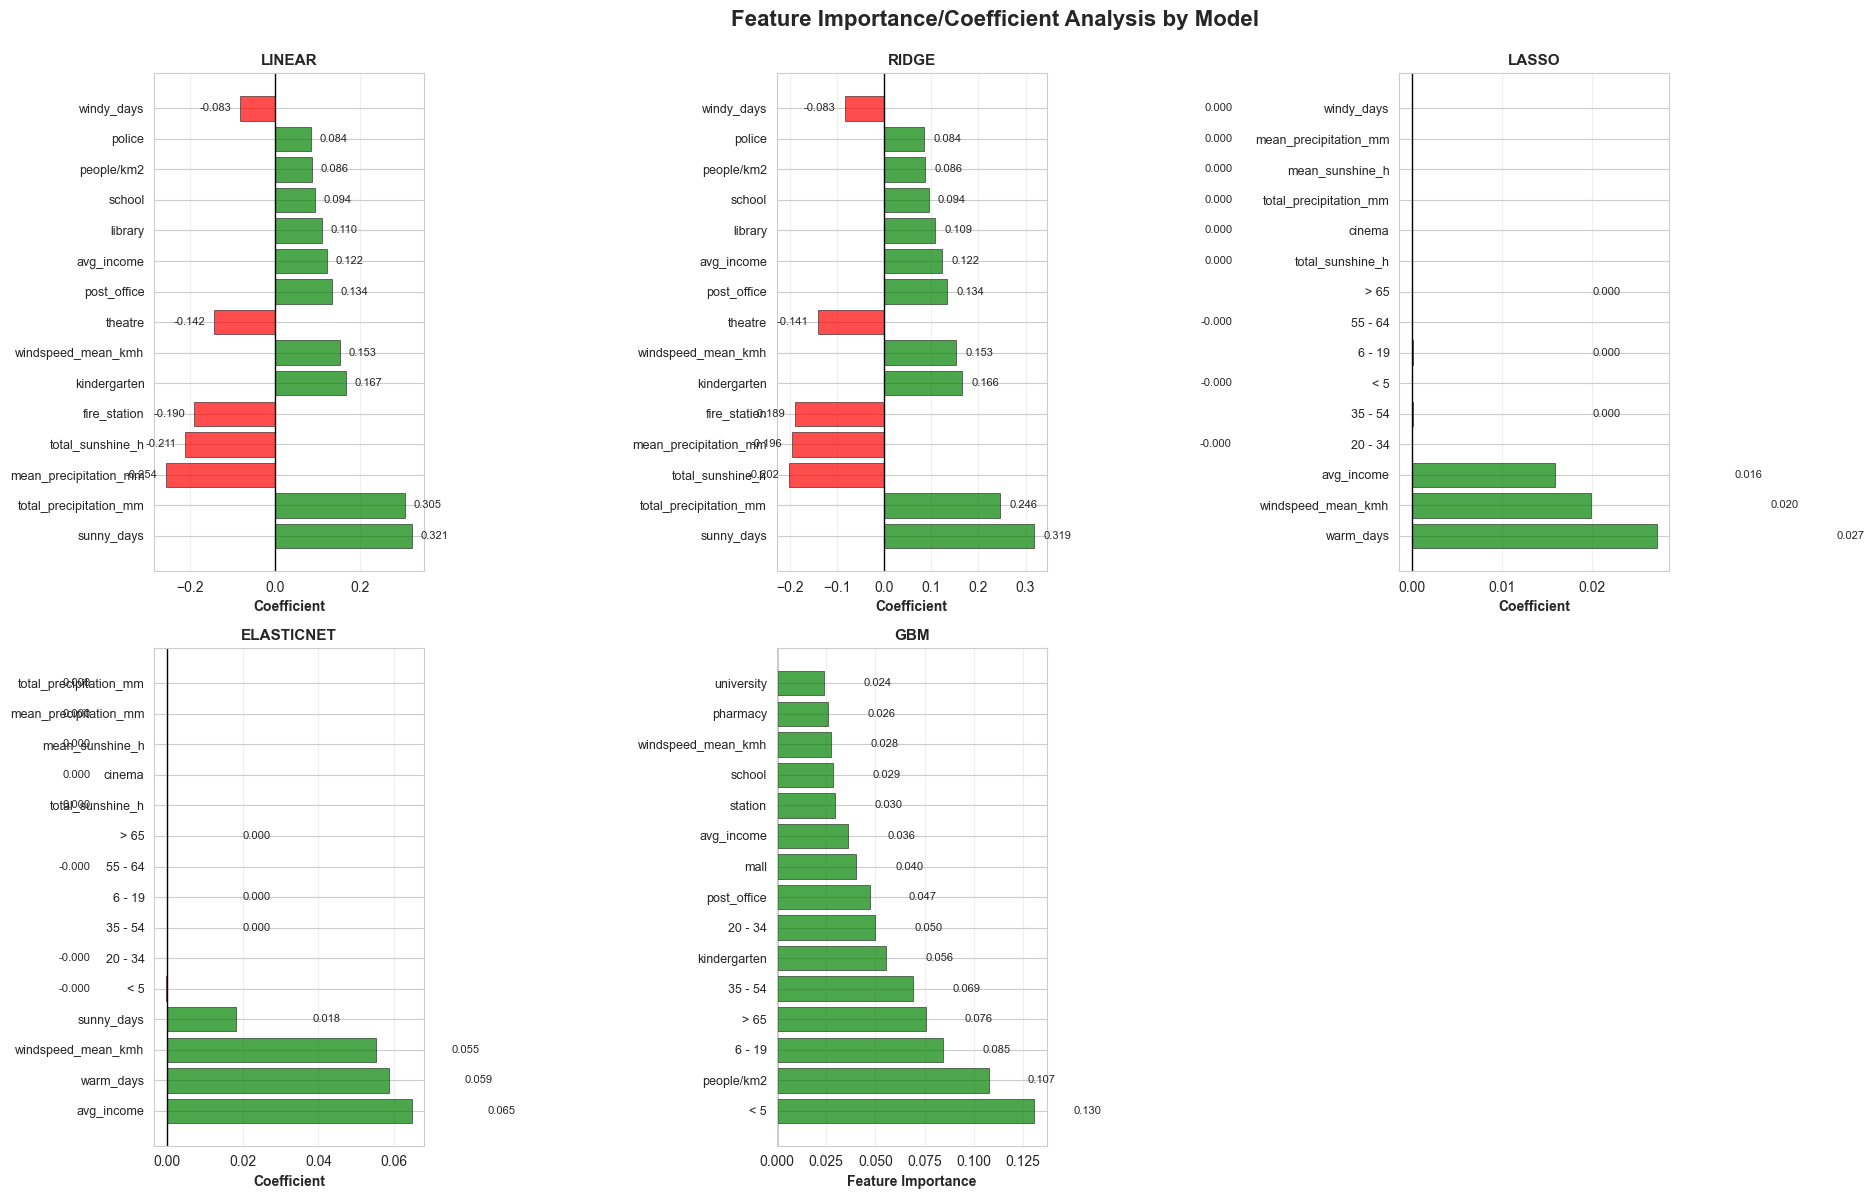

In [48]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle("Feature Importance/Coefficient Analysis by Model", fontsize=16, fontweight='bold', y=0.995)
axes = axes.flatten()

for idx, (model_key, importance_df) in enumerate(feature_importance_data.items()):
    ax = axes[idx]

    top_features = importance_df.head(15).copy()

    value_col = [col for col in top_features.columns if col != "Feature"][0]

    colors = ['green' if x > 0 else 'red' for x in top_features[value_col]]
    bars = ax.barh(
        range(len(top_features)),
        top_features[value_col],
        color=colors,
        alpha=0.7,
        edgecolor='black',
        linewidth=0.5
    )

    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features["Feature"], fontsize=9)

    ax.set_xlabel(value_col, fontsize=10, fontweight='bold')
    ax.set_title(f"{model_key.upper()}", fontsize=11, fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax.grid(True, alpha=0.3, axis='x')

    for i, (bar, val) in enumerate(zip(bars, top_features[value_col])):
        label_x = val + (0.02 if val > 0 else -0.02)
        ha = 'left' if val > 0 else 'right'
        ax.text(label_x, bar.get_y() + bar.get_height()/2, f'{val:.3f}',
                va='center', ha=ha, fontsize=8)

for idx in range(len(feature_importance_data), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


Top 20 Features by Average |Coefficient| Across Linear Models:


,Feature,linear,ridge,lasso,elasticnet
0,sunny_days,0.3212,0.3189,0.0000,0.0184
1,total_precipitation_mm,0.3050,0.2465,0.0000,0.0000
2,mean_precipitation_mm,-0.2544,-0.1964,0.0000,0.0000
3,total_sunshine_h,-0.2107,-0.2022,0.0000,0.0000
4,windspeed_mean_kmh,0.1531,0.1529,0.0199,0.0551
5,fire_station,-0.1898,-0.1890,0.0000,0.0000
6,kindergarten,0.1669,0.1659,0.0000,0.0000
7,avg_income,0.1223,0.1223,0.0158,0.0646
8,theatre,-0.1421,-0.1413,0.0000,0.0000
9,post_office,0.1344,0.1340,0.0000,0.0000


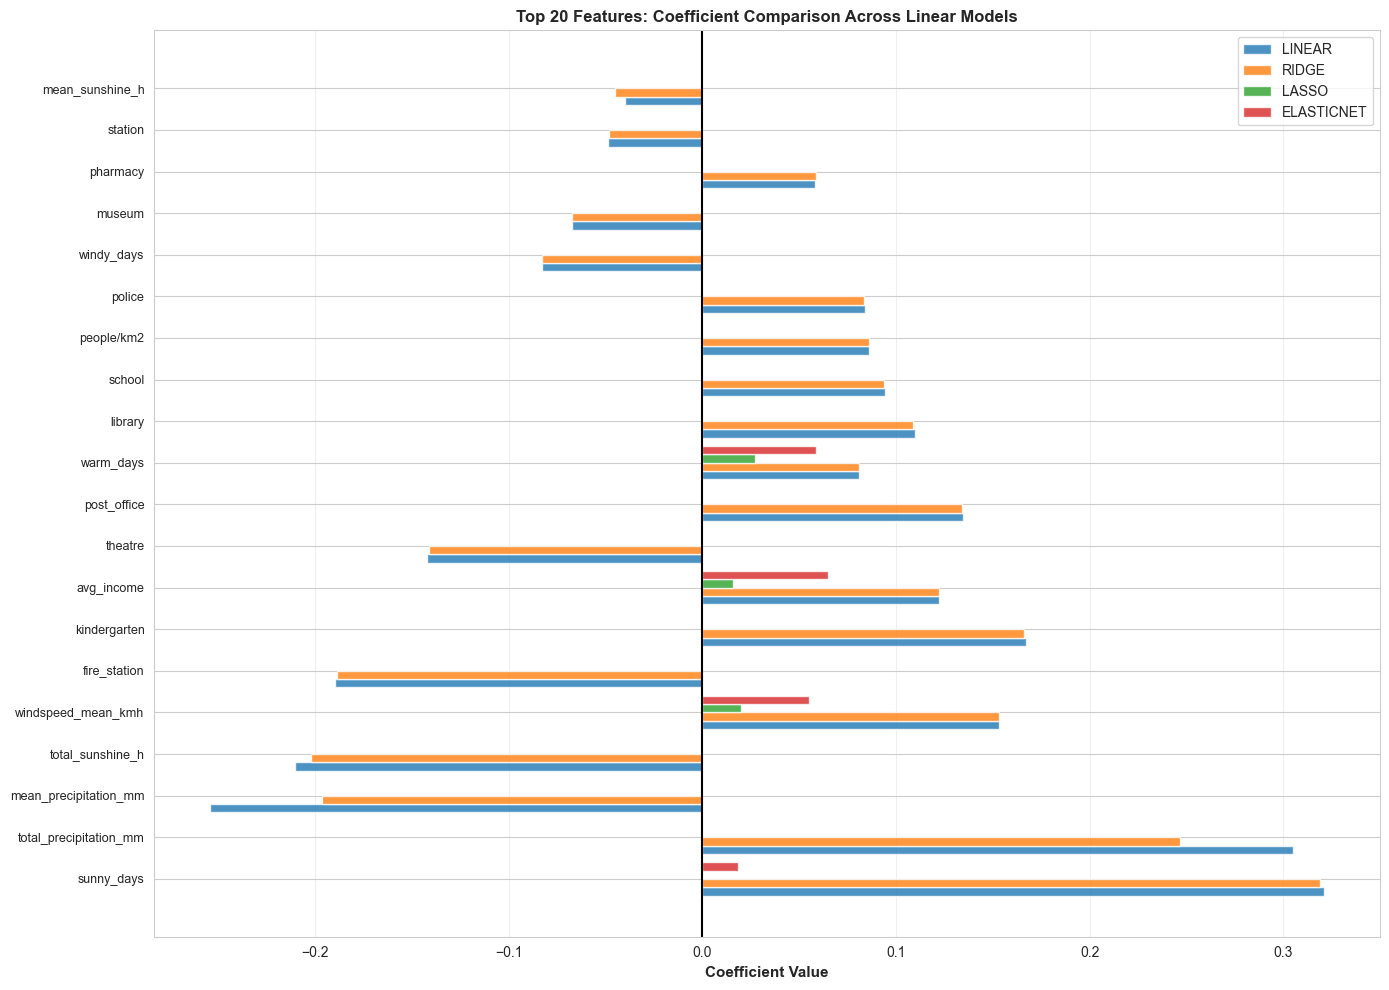

In [49]:
linear_models = {k: v for k, v in feature_importance_data.items() 
                 if "Coefficient" in v.columns}

if linear_models:
    comparison_df = pd.DataFrame({"Feature": feature_names})
    
    for model_key, importance_df in linear_models.items():
        comparison_df = comparison_df.merge(
            importance_df.rename(columns={"Coefficient": model_key}),
            on="Feature",
            how="left"
        )

    model_cols = [col for col in comparison_df.columns if col != "Feature"]
    comparison_df["mean_abs"] = comparison_df[model_cols].abs().mean(axis=1)
    comparison_df = comparison_df.sort_values("mean_abs", ascending=False).reset_index(drop=True)

    print("\nTop 20 Features by Average |Coefficient| Across Linear Models:")
    display(comparison_df.drop(columns=["mean_abs"]).head(20).style.format({
        col: "{:.4f}" for col in model_cols
    }).background_gradient(cmap="RdYlGn", axis=None))
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    top_20 = comparison_df.head(20)
    x_pos = np.arange(len(top_20))
    width = 0.8 / len(model_cols)
    
    for i, model_col in enumerate(model_cols):
        offset = (i - len(model_cols)/2) * width + width/2
        ax.barh(x_pos + offset, top_20[model_col], width, 
                label=model_col.upper(), alpha=0.8)
    
    ax.set_yticks(x_pos)
    ax.set_yticklabels(top_20["Feature"], fontsize=9)
    ax.set_xlabel("Coefficient Value", fontsize=11, fontweight='bold')
    ax.set_title("Top 20 Features: Coefficient Comparison Across Linear Models", 
                 fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=1.5)
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
else:
    print(" No linear models with coefficients available for comparison")

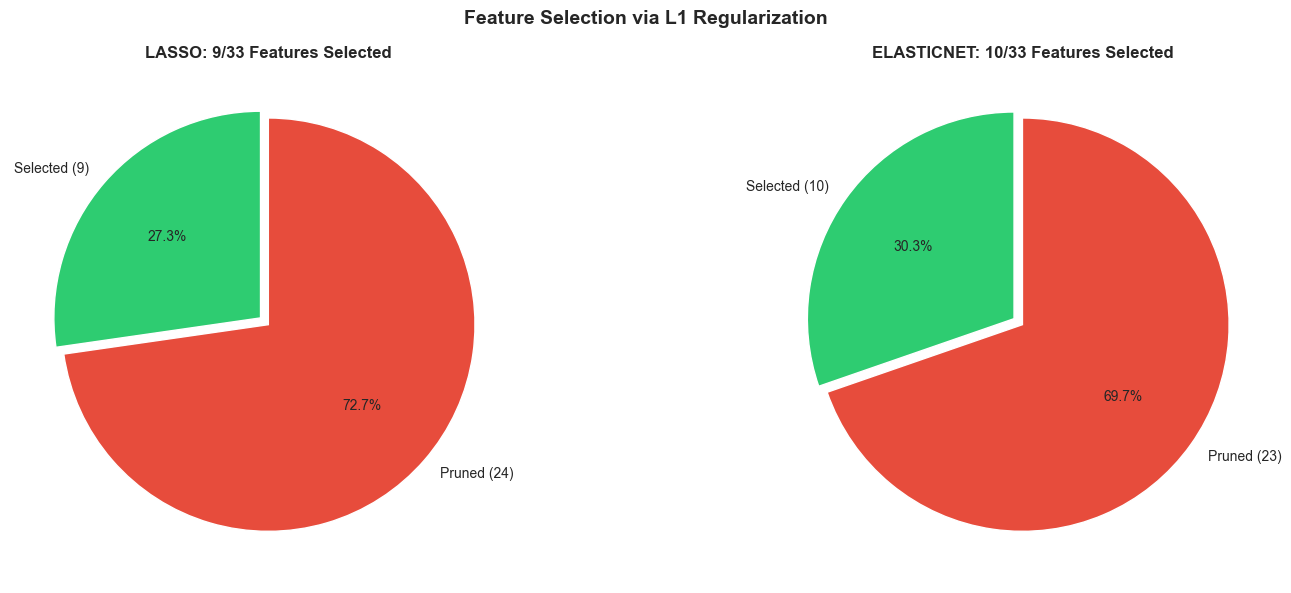


LASSO - Pruned Features (24):
   1. total_sunshine_h
   2. cinema
   3. total_precipitation_mm
   4. mean_sunshine_h
   5. mean_precipitation_mm
   6. windy_days
   7. rainy_days
   8. sunny_days
   9. mall
  10. library
  11. kindergarten
  12. hospital
  13. fire_station
  14. courthouse
  15. college
  16. museum
  17. university
  18. theatre
  19. station
  20. school
  ... and 4 more

ELASTICNET - Pruned Features (23):
   1. total_sunshine_h
   2. cinema
   3. mean_sunshine_h
   4. mean_precipitation_mm
   5. total_precipitation_mm
   6. rainy_days
   7. windy_days
   8. mall
   9. library
  10. kindergarten
  11. hospital
  12. fire_station
  13. courthouse
  14. college
  15. museum
  16. university
  17. theatre
  18. station
  19. school
  20. post_office
  ... and 3 more



In [50]:
l1_models = {k: v for k, v in feature_importance_data.items() 
             if k in ["lasso", "elasticnet"]}

if l1_models:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle("Feature Selection via L1 Regularization", fontsize=14, fontweight='bold')
    
    for idx, (model_key, importance_df) in enumerate(l1_models.items()):
        ax = axes[idx]

        coeffs = importance_df["Coefficient"].values
        zero_count = (coeffs == 0).sum()
        nonzero_count = (coeffs != 0).sum()

        ax.pie(
            [nonzero_count, zero_count],
            labels=[f"Selected ({nonzero_count})", f"Pruned ({zero_count})"],
            autopct='%1.1f%%',
            colors=['#2ecc71', '#e74c3c'],
            startangle=90,
            explode=(0.05, 0)
        )
        ax.set_title(f"{model_key.upper()}: {nonzero_count}/{len(coeffs)} Features Selected",
                     fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

    for model_key, importance_df in l1_models.items():
        pruned_features = importance_df[importance_df["Coefficient"] == 0]["Feature"].tolist()
        if pruned_features:
            print(f"\n{model_key.upper()} - Pruned Features ({len(pruned_features)}):")
            for i, feat in enumerate(pruned_features[:20], 1):
                print(f"  {i:2}. {feat}")
            if len(pruned_features) > 20:
                print(f"  ... and {len(pruned_features) - 20} more")
else:
    print("No L1-regularized models available for feature selection analysis")

print(f"\n{'=' * 80}")

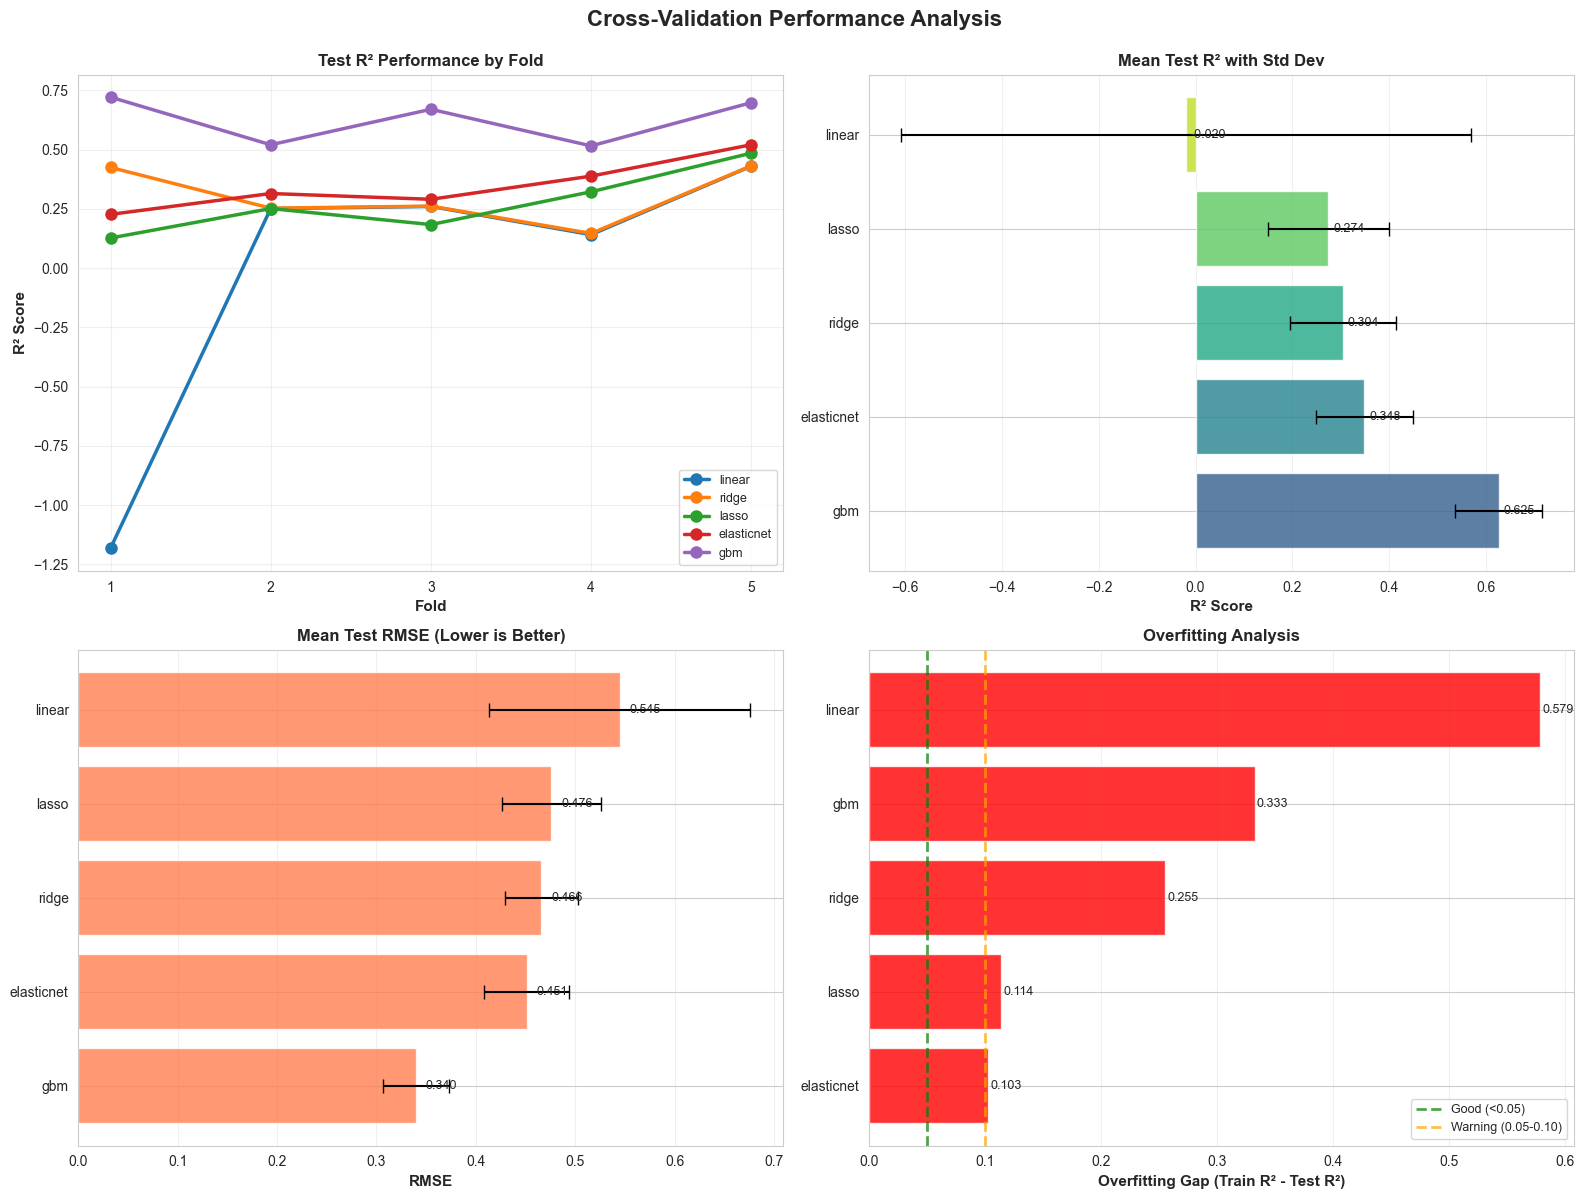

In [51]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Cross-Validation Performance Analysis", fontsize=16, fontweight='bold', y=0.995)

ax = axes[0, 0]
for model_key in cv_results.keys():
    test_r2 = cv_results[model_key]["test_r2"]
    ax.plot(range(1, n_splits + 1), test_r2, marker='o', label=model_key, linewidth=2.5, markersize=8)

ax.set_xlabel("Fold", fontsize=11, fontweight='bold')
ax.set_ylabel("R² Score", fontsize=11, fontweight='bold')
ax.set_title("Test R² Performance by Fold", fontsize=12, fontweight='bold')
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xticks(range(1, n_splits + 1))

ax = axes[0, 1]
model_names = list(cv_results.keys())
test_r2_means = [cv_results[m]["test_r2"].mean() for m in model_names]
test_r2_stds = [cv_results[m]["test_r2"].std() for m in model_names]

sorted_idx = np.argsort(test_r2_means)[::-1]
sorted_names = [model_names[i] for i in sorted_idx]
sorted_means = [test_r2_means[i] for i in sorted_idx]
sorted_stds = [test_r2_stds[i] for i in sorted_idx]

colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(sorted_names)))
bars = ax.barh(sorted_names, sorted_means, xerr=sorted_stds, capsize=5, alpha=0.8, color=colors)
ax.set_xlabel("R² Score", fontsize=11, fontweight='bold')
ax.set_title("Mean Test R² with Std Dev", fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

for i, (bar, mean) in enumerate(zip(bars, sorted_means)):
    ax.text(mean + 0.01, bar.get_y() + bar.get_height()/2, f'{mean:.3f}', 
            va='center', fontsize=9)

ax = axes[1, 0]
test_rmse_means = [np.sqrt(-cv_results[m]["test_neg_mse"]).mean() for m in model_names]
test_rmse_stds = [np.sqrt(-cv_results[m]["test_neg_mse"]).std() for m in model_names]

sorted_idx_rmse = np.argsort(test_rmse_means)
sorted_names_rmse = [model_names[i] for i in sorted_idx_rmse]
sorted_rmse_means = [test_rmse_means[i] for i in sorted_idx_rmse]
sorted_rmse_stds = [test_rmse_stds[i] for i in sorted_idx_rmse]

bars = ax.barh(sorted_names_rmse, sorted_rmse_means, xerr=sorted_rmse_stds, capsize=5, color='coral', alpha=0.8)
ax.set_xlabel("RMSE", fontsize=11, fontweight='bold')
ax.set_title("Mean Test RMSE (Lower is Better)", fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

for bar, rmse in zip(bars, sorted_rmse_means):
    ax.text(rmse + 0.01, bar.get_y() + bar.get_height()/2, f'{rmse:.3f}', 
            va='center', fontsize=9)

ax = axes[1, 1]
train_r2_means = [cv_results[m]["train_r2"].mean() for m in model_names]
overfitting_gaps = [train_r2_means[i] - test_r2_means[i] for i in range(len(model_names))]

colors_overfit = ['green' if gap < 0.05 else 'orange' if gap < 0.10 else 'red' for gap in overfitting_gaps]
sorted_idx_overfit = np.argsort(overfitting_gaps)
sorted_names_overfit = [model_names[i] for i in sorted_idx_overfit]
sorted_gaps = [overfitting_gaps[i] for i in sorted_idx_overfit]
sorted_colors = [colors_overfit[i] for i in sorted_idx_overfit]

bars = ax.barh(sorted_names_overfit, sorted_gaps, color=sorted_colors, alpha=0.8)
ax.set_xlabel("Overfitting Gap (Train R² - Test R²)", fontsize=11, fontweight='bold')
ax.set_title("Overfitting Analysis", fontsize=12, fontweight='bold')
ax.axvline(x=0.05, color='green', linestyle='--', label='Good (<0.05)', alpha=0.7, linewidth=2)
ax.axvline(x=0.10, color='orange', linestyle='--', label='Warning (0.05-0.10)', alpha=0.7, linewidth=2)
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3, axis='x')

for bar, gap in zip(bars, sorted_gaps):
    ax.text(gap + 0.002, bar.get_y() + bar.get_height()/2, f'{gap:.3f}', 
            va='center', fontsize=9)

plt.tight_layout()
plt.show()

## ELASTICNET

In [52]:
# Cell 11: Select Final Production Model

best_model_key = results_df.iloc[0]["Model"]
final_pipeline = trained_pipelines[best_model_key]

if best_model_key in feature_importance_data:
    final_importance_df = feature_importance_data[best_model_key]
    value_col = [col for col in final_importance_df.columns if col != "Feature"][0]
    
    print(f"\n  Top 10 Features (by |{value_col}|):")
    for idx, row in final_importance_df.head(10).iterrows():
        feature = row["Feature"]
        value = row[value_col]
        sign = "+" if value > 0 else "-"
        print(f"    {sign} {feature:30} {value:8.4f}")
    
    # Store for Cell 13
    final_importances = final_importance_df[value_col].values
    importance_type = value_col
else:
    final_importances = None
    importance_type = None




  Top 10 Features (by |Feature Importance|):
    + < 5                              0.1305
    + people/km2                       0.1075
    + 6 - 19                           0.0845
    + > 65                             0.0755
    + 35 - 54                          0.0694
    + kindergarten                     0.0556
    + 20 - 34                          0.0499
    + post_office                      0.0471
    + mall                             0.0401
    + avg_income                       0.0360


In [53]:
MODELS_DIR.mkdir(parents=True, exist_ok=True)

model_path = MODELS_DIR / f"{best_model_key}_final_model.joblib"
joblib.dump(final_pipeline, model_path)

results_path = MODELS_DIR / "cv_results.csv"
results_df.to_csv(results_path, index=False)